# Budowa modelu - część 3

Poprawki wprowadzone po uwzględnieniu uwag zespołu walidacji zostały dodane kolorem <font color="green">zielonym</font>.

Komentarze od zespołu walidacyjnego zostały dodane kolorem <font color="red">czerwonym</font>


## Plan projektu

1. Import potrzebnych pakietów i bibliotek
2. Wczytanie danych
3. Analiza działania różnych algorytmów klasteryzacji
    - 3.1. KMeans
    - 3.2. DBSCAN
    - 3.3. Klasteryzacja hierarchiczna:
        - Hierarchical Agglomerative Clustering (HAC)
        - Divisive Clustering (DIANA)
4. Wybór i ocena algorytmów
5. Wnioski 


## 1. Import potrzebnych pakietów

Zacznijmy od zaimportowania niezbędnych pakietów oraz bibliotek.

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import DBSCAN
from textblob import TextBlob
from nltk.corpus import wordnet
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances, pairwise_distances
from textblob import TextBlob
import nltk
from gensim.models import KeyedVectors
import gensim.downloader as api
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

c:\Users\jakub\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\jakub\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jakub\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jakub\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jakub\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 2. Wczytanie danych

Teraz załadujemy dane, które otrzymaliśmy w drugim kroku budowy. Będziemy testować algorytmy dla dwóch ramek danych otrzymanych w wyniku drugiego etapu budowy: jedna zawierająca 400 kolumn, a druga 598.

<font color="green">Zespół walidacji słusznie zwrócił uwagę, że otrzymane w wyniku etapu 2 wykresy łokcia czy silhouette odbiegają od modelowych oraz nie przyjmują wartości, które mogłyby sugerować poprawne działanie modelu. Zdecydowałyśmy się więc dodać do testowania algorytmów ramki: word2vec_features, tfidf_features, ngram_features, glove_features - jeszcze niepołączone nowe cechy otrzymane w drugim etapie budowy</font>.


In [5]:
df_train400 = pd.read_csv('data\\features_reduced_400.csv')
df_train598 = pd.read_csv('data\\features_reduced_598.csv')
df_word2vec = pd.read_csv('data\\word2vec_features.csv')
df_tfidf = pd.read_csv('data\\tfidf_features.csv') # dodatkowo przeprowadzono PCA
df_ngram = pd.read_csv('data\\ngram_features.csv') # dodatkowo przeprowadzono PCA
df_glove = pd.read_csv('data\\glove_features.csv')

In [26]:
df_train400.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,390,391,392,393,394,395,396,397,398,399
0,0,8.437825,1.223513,4.464734,7.258759,1.573703,-3.176344,-3.688026,-2.196271,2.292232,...,-4.165967,1.675841,2.289226,2.214815,1.497128,-0.340083,2.286668,-4.863132,-0.474057,3.696322
1,1,-8.335973,-4.321551,-8.074836,7.893134,5.608773,3.340850,-2.431535,-5.164856,6.746960,...,0.643104,-1.771653,-1.740464,-1.915328,-0.381786,0.575783,1.033577,2.676367,-0.630713,-0.534133
2,2,-15.605966,-1.464247,-18.301250,15.059916,-12.532350,-4.124209,-2.198932,0.510056,-13.036652,...,-2.100367,0.374303,-1.740562,2.338103,3.218987,0.890181,0.511637,-0.296552,0.590216,3.505624
3,3,-14.518597,-1.788423,-12.207942,8.988366,-4.172523,-1.700795,-0.662889,-0.171635,-5.740693,...,0.337835,-2.655234,2.117434,-2.866540,0.411002,-1.564702,1.728826,1.365479,0.591765,-5.258426
4,4,10.892859,3.464815,-4.887657,-5.072349,0.489982,1.597838,5.228906,-8.231812,1.019109,...,4.050798,-2.078065,1.986094,-1.828739,0.507606,-1.948571,-0.866970,-1.025715,-0.154473,-1.761774


In [27]:
df_train598.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,588,589,590,591,592,593,594,595,596,597
0,0,8.437826,1.223512,4.464724,7.258750,1.573859,-3.177362,-3.687467,-2.197288,2.291994,...,-0.509341,1.344865,0.957335,-1.110530,2.711292,-0.425064,-0.126448,3.207902,2.965989,-6.664061
1,1,-8.335975,-4.321570,-8.074838,7.893218,5.608623,3.340440,-2.431817,-5.164040,6.748891,...,0.761198,0.000542,-0.331378,2.023028,2.247459,2.048850,-0.733114,-0.087888,-3.799397,0.086988
2,2,-15.605963,-1.464258,-18.301302,15.059906,-12.532604,-4.124226,-2.200301,0.507464,-13.034558,...,-3.140074,-0.075793,-1.142219,0.755568,-3.096423,0.027670,-0.356879,-2.843012,-0.745095,-0.721840
3,3,-14.518596,-1.788435,-12.207957,8.988424,-4.172721,-1.700930,-0.661729,-0.170463,-5.742334,...,-1.171829,1.371767,0.747869,-3.014606,2.521298,-3.433612,-0.301280,-0.492414,-0.953216,4.075033
4,4,10.892867,3.464804,-4.887648,-5.072226,0.489851,1.597361,5.228424,-8.229514,1.019225,...,-2.204402,7.618616,-1.074306,3.122334,1.245111,-0.827169,-1.466426,2.320238,0.869485,-0.112714


In [285]:
df_word2vec.head()

,word2vec_0,word2vec_1,word2vec_2,word2vec_3,word2vec_4,word2vec_5,word2vec_6,word2vec_7,word2vec_8,word2vec_9,...,word2vec_290,word2vec_291,word2vec_292,word2vec_293,word2vec_294,word2vec_295,word2vec_296,word2vec_297,word2vec_298,word2vec_299
0,0.113330,0.206937,0.236347,1.830548,0.757145,-0.506441,1.672126,-3.682586,4.599880,2.758439,...,-0.702018,0.959570,-3.623198,-1.145071,0.533438,-2.024621,-2.657264,-1.681207,0.475555,0.419204
1,0.819902,1.158105,-0.624706,2.674979,-0.790713,0.065025,0.516192,-2.091157,4.580892,3.237372,...,-2.090565,2.057482,-2.999995,1.008312,0.243764,0.640927,-0.095508,0.167788,1.524980,-1.811537
2,0.633466,1.960367,-1.694114,5.445454,-1.507721,-2.423164,0.852693,-4.203136,5.813747,3.030889,...,-2.434987,1.266202,-0.949797,-0.897689,-1.025261,-1.184450,-1.714672,0.558538,2.324161,-1.795527
3,0.819997,0.981675,-0.522519,2.909155,-0.704411,-2.056313,1.360760,-3.492091,4.516929,2.950277,...,-2.051928,1.427495,-2.605310,0.612674,-1.756724,-2.021972,-1.118272,-0.482575,0.005503,-1.549822
4,-0.135380,1.222527,1.094022,3.038881,-0.375444,-0.438021,3.026120,-3.975449,2.698960,2.750002,...,-0.368020,4.081200,-1.665631,1.393663,-0.387975,0.031404,0.226133,-2.828371,0.307086,-0.295515


In [286]:
df_tfidf.head()

,aaa,abandon,abba,abbas,abbott,abc,abide,ability,able,abolish,...,yuganskneftegas,yuganskneftegaz,yukos,yushchenko,zealand,zero,zimbabwe,zombie,zone,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [287]:
df_ngram.head()

,ac milan,academy award,accord report,accord research,account deficit,accuse mr,aer lingus,affair spokesman,air deccan,alan milburn,...,year also,year earlier,year first,year however,year make,year mr,year oscar,year say,young people,young player
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [288]:
df_glove.head()

,glove_0,glove_1,glove_2,glove_3,glove_4,glove_5,glove_6,glove_7,glove_8,glove_9,...,glove_290,glove_291,glove_292,glove_293,glove_294,glove_295,glove_296,glove_297,glove_298,glove_299
0,1.068720,1.317883,1.088049,1.249776,-0.746980,0.958553,0.176394,-0.496528,-1.550964,-2.340549,...,-0.335578,-0.047280,1.009898,1.229615,0.211738,0.387084,0.015756,-0.413267,-2.673928,1.122523
1,-0.290954,-0.043945,-0.503066,-0.357666,1.788324,0.829599,0.412546,1.230808,0.238079,-4.507431,...,0.472128,-0.684052,-1.483127,-0.204112,1.825258,2.279662,0.191437,-1.810676,-0.480040,-0.507190
2,-0.300442,0.756171,-1.228046,-0.514646,1.527615,0.683296,0.342118,2.439855,-0.020839,-5.453042,...,-0.673859,0.553372,-0.580774,0.753498,2.491407,3.050676,-1.832102,-1.670224,-0.476913,-0.329073
3,-0.933285,2.041570,-0.504293,-0.877826,-0.593858,-0.042243,0.548926,0.957999,-0.916964,-5.335359,...,-0.237230,-0.737937,-0.768770,0.323105,2.132590,2.939880,-1.467226,-2.698983,-1.150346,-0.990289
4,0.150241,3.335528,-1.858249,0.415560,0.916567,-0.567206,-1.864484,0.338452,0.235106,-3.172512,...,-0.437959,1.165186,-0.575531,0.983114,2.121427,-0.630827,-0.712701,-2.228985,-1.470560,0.224461


Jak widać, mamy tabele z wartościami liczbowymi (sposób ich otrzymania został dokładniej opisany w poprzednim kroku budowy). Na tym etapie projektu do wyboru i trenowania modeli odejdziemy od słów, a skupimy się na zwektoryzowanych danych. Zmieńmy typ danych, żeby móc sprawdzić, jak poradzą sobie różne algorytmy.

In [6]:
df_train400 = df_train400.values
df_train598 = df_train598.values
df_word2vec = df_word2vec.values
df_tfidf = df_tfidf.values
df_ngram = df_ngram.values
df_glove = df_glove.values

## 3. Analiza działania różnych algorytmów klasteryzacji

### 3.1. KMeans

Zaczniemy od przeprowadzenia klasteryzacji przy użyciu algorytmu Kmeans. Zdefiniujmy funkcję, która wytrenuje model, przewidzi wynik oraz narysuje wykres.

In [8]:
def kmeans_plot(X, n_clusters):
    # inicjalizacja KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    # dopasowanie modelu do danych
    kmeans.fit(X)
    # przewidywanie wyniku
    y_kmeans = kmeans.predict(X)

    # Redukcja wymiarów za pomocą PCA do 2D dla wizualizacji
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)

    # rysowanie klastrów
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_kmeans, s=15, cmap='viridis')

    # centra klastrów
    # centers = kmeans.cluster_centers_
    # plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)

    plt.title('Klasteryzacja KMeans')
    plt.show()
    return y_kmeans

def clusterization_scores(X, labels):

    # silhouette score
    silh = silhouette_score(X, labels)
    print(f'Silhouette Score: {silh}')

    # Davies-Bouldin Index
    dbi = davies_bouldin_score(X, labels)
    print(f'Davies-Bouldin Index: {dbi}')

    # Calinski-Harabasz Index
    chs = calinski_harabasz_score(X, labels)
    print(f'Calinski-Harabasz Index: {chs}')

    return silh, dbi, chs

    


Na drugim etapie budowy zdecydowałyśmy, że najbardziej optymalną liczbą klastrów będzie 5. Dla tej wartości rozpoczniemy klasteryzację.
<font color="green">Po uwzględnieniu uwag zespołu walidacyjnego wartość 5 nie będzie już tą dominującą - będziemy sprawdzać wyniki dla różnych wartości.</font>
Zacznijmy od ramki danych z 400 kolumnami.

#### features_reduced_400

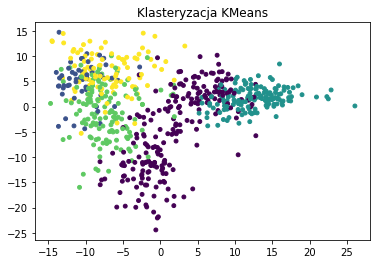

In [9]:
y_kmeans400 = kmeans_plot(df_train400, n_clusters=5)

In [10]:
kmeans_silh400, kmeans_dbi400, kmeans_chs400 = clusterization_scores(df_train400, y_kmeans400)

Silhouette Score: 0.0398514680368861
Davies-Bouldin Index: 4.241543169531496
Calinski-Harabasz Index: 21.05405406718158


#### features_reduced_598

Teraz ramka danych z 598 kolumnami.

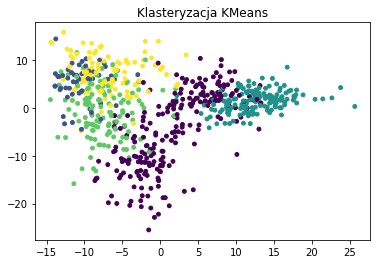

In [11]:
y_kmeans598 = kmeans_plot(df_train598, n_clusters=5)

In [12]:
kmeans_silh598, kmeans_dbi598, kmeans_chs598 = clusterization_scores(df_train598, y_kmeans598)

Silhouette Score: 0.036877270659219794
Davies-Bouldin Index: 4.338805112750367
Calinski-Harabasz Index: 19.93072699093308


#### word2vec_features

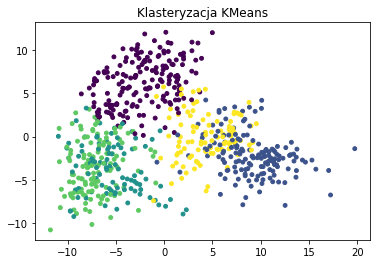

In [13]:
y_kmeans_w2v = kmeans_plot(df_word2vec, n_clusters = 5)

In [14]:
kmeans_silh_w2v, kmeans_dbi_w2v, kmeans_chs_w2v = clusterization_scores(df_word2vec, y_kmeans_w2v)

Silhouette Score: 0.1256896040317868
Davies-Bouldin Index: 2.2910168151747556
Calinski-Harabasz Index: 62.31531170284354


<font color="green">Widzimy, że punkty na wykresie rzeczywiście rozkładają sie inaczej. Sprawdźmy kolejne tabelki.</font>


#### tfidf_features

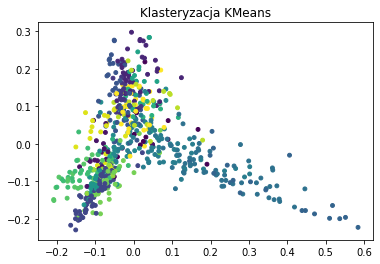

In [15]:
y_kmeans_tfidf = kmeans_plot(df_tfidf, n_clusters = 20)

In [16]:
kmeans_silh_tfidf, kmeans_dbi_tfidf, kmeans_chs_tfidf = clusterization_scores(df_tfidf, y_kmeans_tfidf)

Silhouette Score: 0.01867296096100047
Davies-Bouldin Index: 5.171165099993904
Calinski-Harabasz Index: 3.683179164352732


#### ngram_features

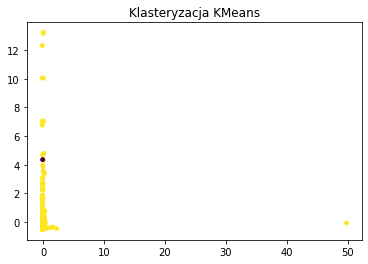

In [17]:
y_kmeans_ngram = kmeans_plot(df_ngram, n_clusters = 2)

In [18]:
kmeans_silh_ngram, kmeans_dbi_ngram, kmeans_chs_ngram = clusterization_scores(df_ngram, y_kmeans_ngram)

Silhouette Score: 0.7023419866648343
Davies-Bouldin Index: 0.20445206316654996
Calinski-Harabasz Index: 16.352565932445923


<font color="red">Wysoki silhouette score dla ramki ngram features oraz metody KMeans, jednak to jedynie efekt wyboru dwóch klastrów. Można byłoby spróbować podejścia, że dla każdej ramki testujemy metryki dla kilku różnych klastrów i następnie wybieramy liczbę klastrów, która ma najwyższy score albo skorzystać z metody łokcia (chyba, że tak zespół budowy zrobił, wtedy jednak warto byłoby to udokumentować w kodzie). Zespołowi walidacji nie podoba się stosowane tu podejście, co do arbitralnego wyboru liczby klastrów dla poszczególnych ramek.</font>  

<font color="red"> Poniżej znajduje się kod napisany przez zespół walidacyjny, który rozwiązuje wcześniej postawiony problem </font>

Clusters: 2, Silhouette Score: 0.7023419866648343
Clusters: 3, Silhouette Score: 0.7047799084766416
Clusters: 4, Silhouette Score: 0.39968918381384605
Clusters: 5, Silhouette Score: 0.16522323993082422
Clusters: 6, Silhouette Score: 0.22862025388476587
Clusters: 7, Silhouette Score: 0.2280645298998049
Clusters: 8, Silhouette Score: 0.2753231783214614
Clusters: 9, Silhouette Score: 0.2291239075811525
Clusters: 10, Silhouette Score: 0.23081991070067312
Best number of clusters: 3, with a Silhouette Score of 0.7047799084766416


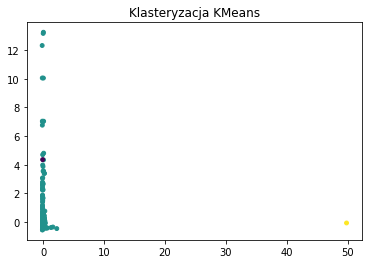

In [131]:
def find_best_cluster(X, min_clusters=2, max_clusters=10):
    best_n_clusters = min_clusters
    best_score = -1

    for n_clusters in range(min_clusters, max_clusters + 1):
        # Inicjalizacja KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        # Dopasowanie modelu do danych
        kmeans.fit(X)
        # Przewidywanie wyniku
        labels = kmeans.predict(X)

        # Obliczanie Silhouette Score
        score = silhouette_score(X, labels)
        print(f'Clusters: {n_clusters}, Silhouette Score: {score}')
        
        # Aktualizacja najlepszego wyniku i liczby klastrów
        if score > best_score:
            best_score = score
            best_n_clusters = n_clusters

    print(f'Best number of clusters: {best_n_clusters}, with a Silhouette Score of {best_score}')

    # Wizualizacja najlepszego klastra
    y_kmeans = kmeans_plot(X, best_n_clusters)

    # Obliczanie i zwracanie wszystkich wskaźników dla najlepszego klastra
    # silh, dbi, chs = clusterization_scores(X, y_kmeans)
    # silh, dbi, chs
    return best_n_clusters, best_score

# Przykład użycia funkcji:
best_n_clusters, best_score = find_best_cluster(df_ngram)

In [128]:
df_ngram

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

#### glove_features

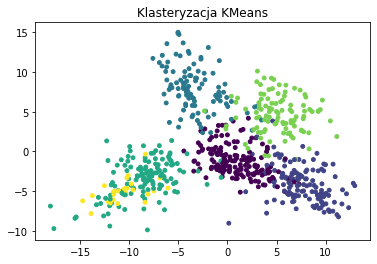

In [19]:
y_kmeans_glove = kmeans_plot(df_glove, n_clusters = 6)

In [20]:
kmeans_silh_glove, kmeans_dbi_glove, kmeans_chs_glove = clusterization_scores(df_glove, y_kmeans_glove)

Silhouette Score: 0.1330732439267444
Davies-Bouldin Index: 2.090381538832712
Calinski-Harabasz Index: 58.9544174472788


#### Podsumowanie:

In [21]:
kmeans_scores = {
    'Data': ['features_reduced_400', 'features_reduced_598', 'word2vec_features', 'tfidf_features', 'ngram_features', 'glove_features'],
    'Silhouette Score': [kmeans_silh400, kmeans_silh598, kmeans_silh_w2v, kmeans_silh_tfidf, kmeans_silh_ngram, kmeans_silh_glove],
    'Davies-Bouldin Score': [kmeans_dbi400, kmeans_dbi598, kmeans_dbi_w2v, kmeans_dbi_tfidf, kmeans_dbi_ngram, kmeans_dbi_glove],
    'Calinski-Harabasz Score': [kmeans_chs400, kmeans_chs598, kmeans_chs_w2v, kmeans_chs_tfidf, kmeans_chs_ngram, kmeans_chs_glove]
    }

kmeans_scores = pd.DataFrame(kmeans_scores)
print(kmeans_scores)

                   Data  Silhouette Score  Davies-Bouldin Score  \
0  features_reduced_400          0.039851              4.241543   
1  features_reduced_598          0.036877              4.338805   
2     word2vec_features          0.125690              2.291017   
3        tfidf_features          0.018673              5.171165   
4        ngram_features          0.702342              0.204452   
5        glove_features          0.133073              2.090382   

   Calinski-Harabasz Score  
0                21.054054  
1                19.930727  
2                62.315312  
3                 3.683179  
4                16.352566  
5                58.954417  


<font color="red">Mimo pokaźnej liczby wykresów nie obserwujemy płynących z nich konstruktywnych wniosków. Przedstawiono wiele wyników poszczególnych metryk, ale zabrakło wyrażonego zdania przez zespół budowy na temat skuteczności i poprawności danej metody klasteryzacji.</font> 

### 3.2. DBSCAN

Zajmiemy się teraz klasteryzacja przy użyciu algorytmu DBSCAN. Stworzymy analogiczną funkcję jak dla KMeans.

In [22]:
def dbscan_plot(X, eps=0.5, min_samples=5):
    # inicjalizacja DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    # dopasowanie DBSCAN do danych
    clusters = dbscan.fit_predict(X)

    # redukcja wymiarowości danych do dwóch wymiarów za pomocą PCA dla wizualizacji
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # rysowanie klastrów
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
    plt.title('Klasteryzacja DBSCAN')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Cluster')
    plt.show()

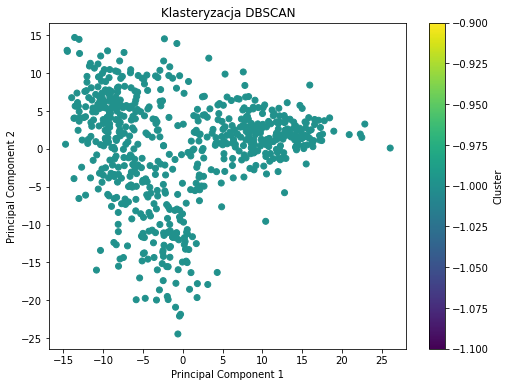

In [23]:
dbscan_plot(df_train400, eps=0.00000000001, min_samples=100)

Teraz dane z 598 kolumnami:

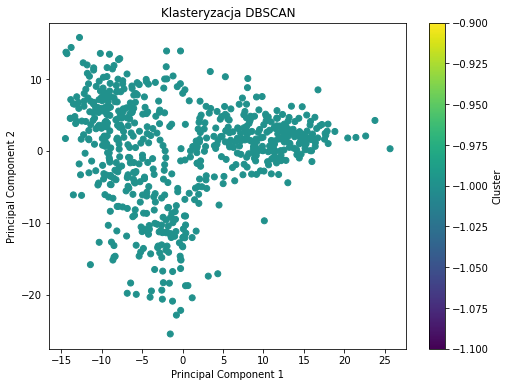

In [24]:
dbscan_plot(df_train598)

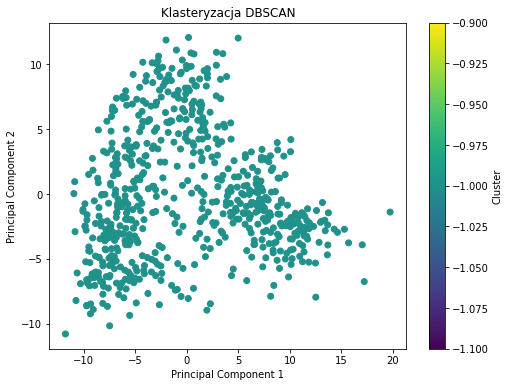

In [25]:
dbscan_plot(df_word2vec)

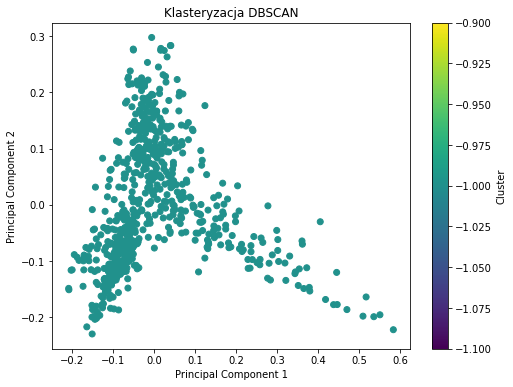

In [26]:
dbscan_plot(df_tfidf)

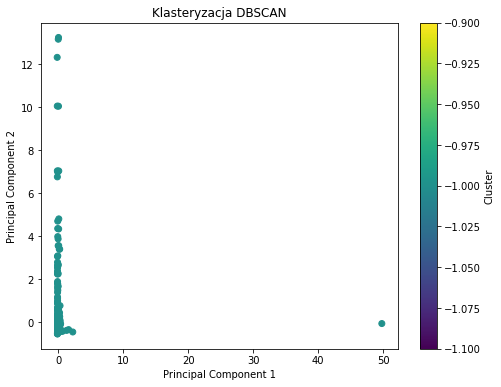

In [27]:
dbscan_plot(df_ngram)

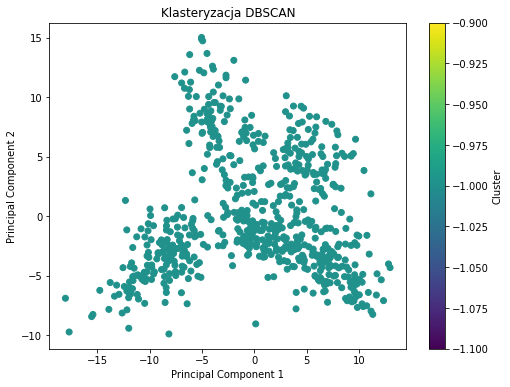

In [28]:
dbscan_plot(df_glove)

Dla tej metody klasteryzacja w ogóle sobie nie radzi. Nie tworzy więcej niż 1 klastra. Nie będziemy więc dalej analizować tego algorytmu.

<font color="red"> Zespół walidacyjny docenia próby uzyskania więcej niż jednego klastra w metodzie DBSCAN. Jednocześnie zespół budowy podjął słuszną decyzje, że model ten nie działa dla tego zbioru i nie ma sensu dalej go rozważać. </font>

### 3.3. Klasteryzacja hierarchiczna

Przejdziemy teraz do algorytmów przeprowadzających klasteryzację w sposób hierarchiczny.

#### Hierarchical Agglomerative Clustering (HAC)

Zacznijmy od Hierarchical Agglomerative Clustering (HAC). Przetestujemy różne rodzaje podejść aglomeracyjnych:
- Single Linkage
- Complete Linkage
- Average Linkage
- Centroid Linkage
- Ward's Linkage.

#### Single Linkage

In [29]:
def single_linkage_plot(X, max_clusters=5):
    # Inicjalizacja algorytmu aglomeracyjnego z użyciem single linkage
    model = AgglomerativeClustering(n_clusters=max_clusters, linkage='single')

    # Dopasowanie modelu do danych
    clusters = model.fit_predict(X)

    # Redukcja wymiarowości danych do dwóch wymiarów za pomocą PCA dla wizualizacji
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Rysowanie klastrów
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
    plt.title('Single Linkage Clustering')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Cluster')
    plt.show()

    return clusters

##### features_reduced_400

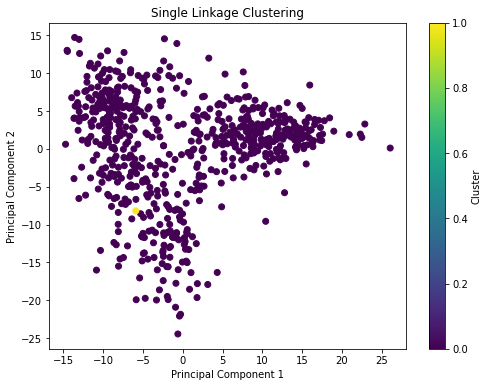

In [30]:
y_sl400 = single_linkage_plot(df_train400, max_clusters=2)

In [31]:
sl_silh400, sl_dbi400, sl_chs400 = clusterization_scores(df_train400, y_sl400)

Silhouette Score: 0.1958733384370551
Davies-Bouldin Index: 0.6886264757337327
Calinski-Harabasz Index: 2.074323651474389


##### features_reduced_598

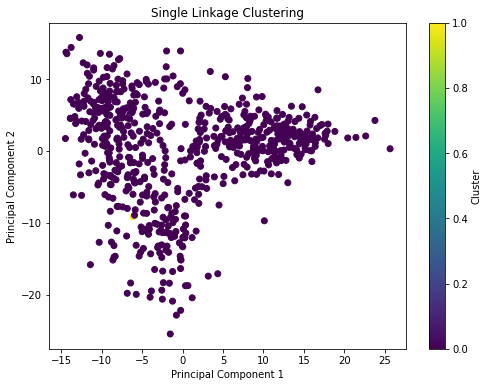

In [32]:
y_sl598 = single_linkage_plot(df_train598, max_clusters=2)

In [33]:
sl_silh598, sl_dbi598, sl_chs598 = clusterization_scores(df_train598, y_sl598)

Silhouette Score: 0.19994781839452058
Davies-Bouldin Index: 0.68345836865253
Calinski-Harabasz Index: 2.10651998232149


##### word2vec_features

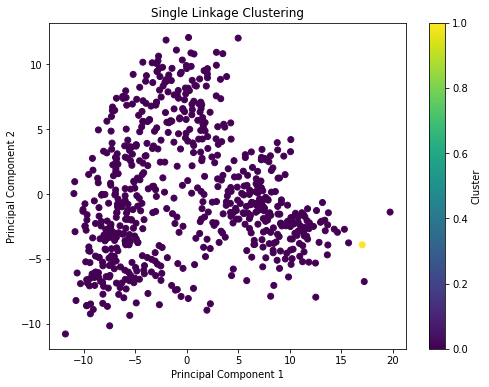

In [34]:
y_sl_w2v = single_linkage_plot(df_word2vec, max_clusters=2)

In [35]:
sl_silh_w2v, sl_dbi_w2v, sl_chs_w2v = clusterization_scores(df_word2vec, y_sl_w2v)

Silhouette Score: 0.33997800473764034
Davies-Bouldin Index: 0.5195102562042166
Calinski-Harabasz Index: 3.590112038528145


##### tfidf_features

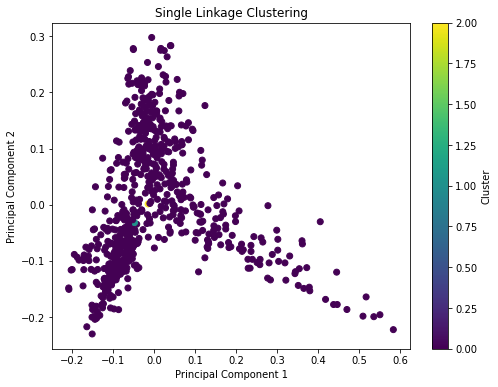

In [36]:
y_sl_tfidf = single_linkage_plot(df_tfidf, max_clusters=3)

In [37]:
sl_silh_tfidf, sl_dbi_tfidf, sl_chs_tfidf = clusterization_scores(df_tfidf, y_sl_tfidf)

Silhouette Score: 0.005559930221726524
Davies-Bouldin Index: 0.9822744429949534
Calinski-Harabasz Index: 1.0349536947422406


##### ngram_features

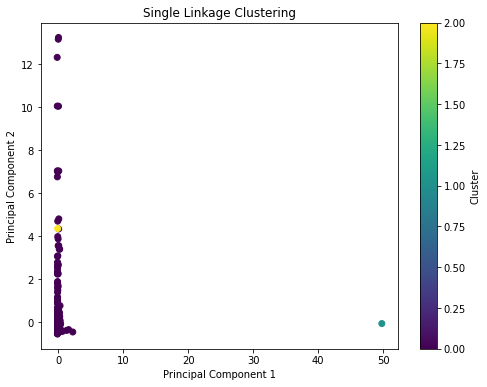

In [38]:
y_sl_ngram = single_linkage_plot(df_ngram, max_clusters=3)

In [39]:
sl_silh_ngram, sl_dbi_ngram, sl_chs_ngram = clusterization_scores(df_ngram, y_sl_ngram)

Silhouette Score: 0.7047799084766416
Davies-Bouldin Index: 0.16744977326585322
Calinski-Harabasz Index: 46.78504693963104


##### glove_features

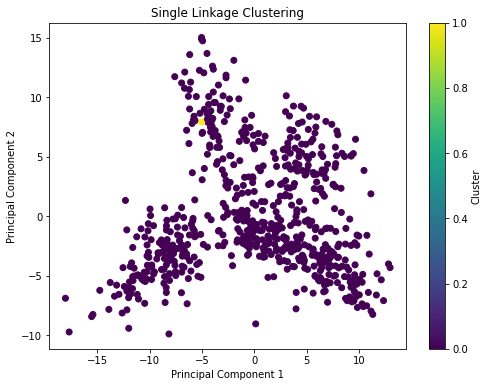

In [40]:
y_sl_glove = single_linkage_plot(df_glove, max_clusters=2)

In [41]:
sl_silh_glove, sl_dbi_glove, sl_chs_glove = clusterization_scores(df_glove, y_sl_glove)

Silhouette Score: 0.2842947259194015
Davies-Bouldin Index: 0.5834443408331875
Calinski-Harabasz Index: 2.8070772270303808


Widać, że ta metoda ogólnie również średnio radzi sobie z klasteryzacją.

##### Podsumowanie

In [44]:
sl_scores = {
    'Data': ['features_reduced_400', 'features_reduced_598', 'word2vec_features', 'tfidf_features', 'ngram_features', 'glove_features'],
    'Silhouette Score': [sl_silh400, sl_silh598, sl_silh_w2v, sl_silh_tfidf, sl_silh_ngram, sl_silh_glove],
    'Davies-Bouldin Score': [sl_dbi400, sl_dbi598, sl_dbi_w2v, sl_dbi_tfidf, sl_dbi_ngram, sl_dbi_glove],
    'Calinski-Harabasz Score': [sl_chs400, sl_chs598, sl_chs_w2v, sl_chs_tfidf, sl_chs_ngram, sl_chs_glove]
    }

sl_scores = pd.DataFrame(sl_scores)
print(sl_scores)

                   Data  Silhouette Score  Davies-Bouldin Score  \
0  features_reduced_400          0.195873              0.688626   
1  features_reduced_598          0.199948              0.683458   
2     word2vec_features          0.339978              0.519510   
3        tfidf_features          0.005560              0.982274   
4        ngram_features          0.704780              0.167450   
5        glove_features          0.284295              0.583444   

   Calinski-Harabasz Score  
0                 2.074324  
1                 2.106520  
2                 3.590112  
3                 1.034954  
4                46.785047  
5                 2.807077  


<font color="red">Bardzo czytelny kod, dobrze zaagregowane wyniki poszczególnych metryk. </font>

#### Complete Linkage

In [45]:
def complete_linkage_clustering(X, max_clusters):
    """
    Przeprowadza klasteryzację Complete Linkage na danych X.
    
    :param X: przekształcone i zwektoryzowane dane tekstowe
    :param max_clusters: maksymalna liczba klastrów
    :return: przyporządkowane klastry dla każdego punktu danych
    """
    # Przeprowadzenie klasteryzacji Complete Linkage
    clustering = AgglomerativeClustering(n_clusters=max_clusters, linkage='complete')
    labels = clustering.fit_predict(X)

    return labels

def complete_linkage_plot(X, max_clusters):
    """
    Przeprowadza klasteryzację Complete Linkage na danych X i rysuje wykres klastrów.
    
    :param X: przekształcone i zwektoryzowane dane tekstowe
    :param max_clusters: maksymalna liczba klastrów
    """
    labels = complete_linkage_clustering(X, max_clusters)

    # Redukcja wymiarów za pomocą PCA do 2D dla wizualizacji
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis')
    plt.title('Klasteryzacja HAC - Complete Linkage')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar()
    plt.show()
    return labels


##### features_reduced_400

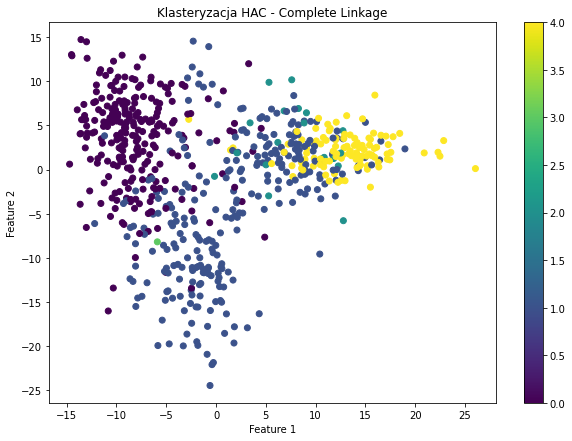

In [46]:
y_cl400 = complete_linkage_plot(df_train400, max_clusters=5)

In [47]:
cl_silh400, cl_dbi400, cl_chs400 = clusterization_scores(df_train400, y_cl400)

Silhouette Score: 0.03162873795972041
Davies-Bouldin Index: 3.5503582109626954
Calinski-Harabasz Index: 14.283341953530465


##### features_reduced_598

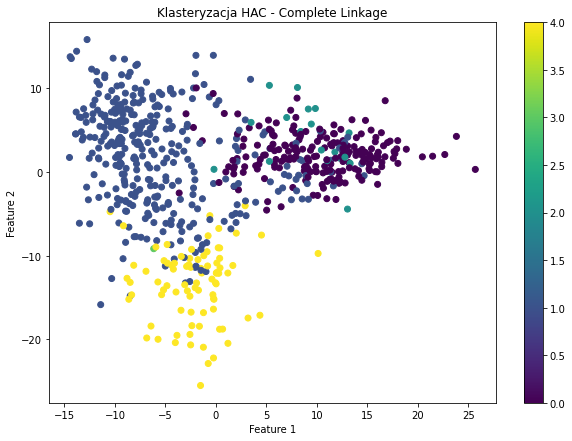

In [48]:
y_cl598 = complete_linkage_plot(df_train598, max_clusters=5)

In [49]:
cl_silh598, cl_dbi598, cl_chs598 = clusterization_scores(df_train598, y_cl598)

Silhouette Score: 0.03581472627040213
Davies-Bouldin Index: 3.2159797070783127
Calinski-Harabasz Index: 13.937352056154172


##### word2vec_features

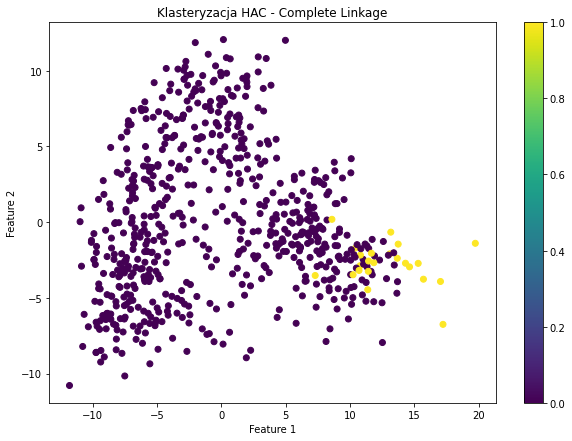

In [50]:
y_cl_w2v = complete_linkage_plot(df_word2vec, max_clusters=2)

In [51]:
cl_silh_w2v, cl_dbi_w2v, cl_chs_w2v = clusterization_scores(df_word2vec, y_cl_w2v)

Silhouette Score: 0.1376840965563808
Davies-Bouldin Index: 1.9208084457093078
Calinski-Harabasz Index: 20.849401359780753


##### tfidf_features

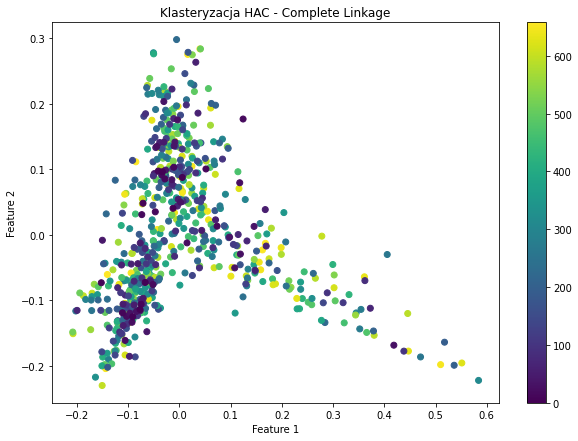

In [53]:
y_cl_tfidf = complete_linkage_plot(df_tfidf, max_clusters=659)

In [60]:
cl_silh_tfidf, cl_dbi_tfidf, cl_chs_tfidf = clusterization_scores(df_tfidf, y_cl_tfidf)

ValueError: Number of labels is 659. Valid values are 2 to n_samples - 1 (inclusive)

##### ngram_features

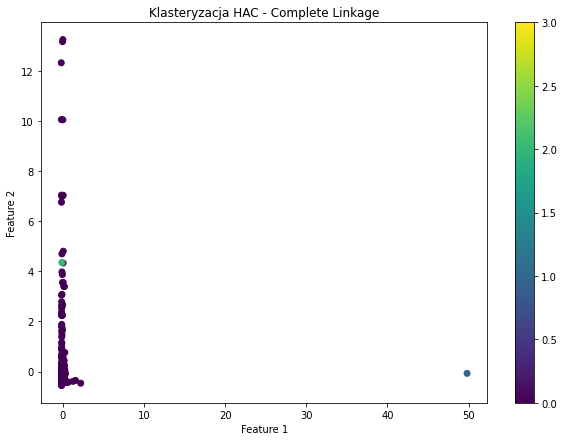

In [55]:
y_cl_ngram = complete_linkage_plot(df_ngram, max_clusters=4)

In [56]:
cl_silh_ngram, cl_dbi_ngram, cl_chs_ngram = clusterization_scores(df_ngram, y_cl_ngram)

Silhouette Score: 0.631242193724473
Davies-Bouldin Index: 0.20314606320705625
Calinski-Harabasz Index: 35.45250222414434


##### glove_features

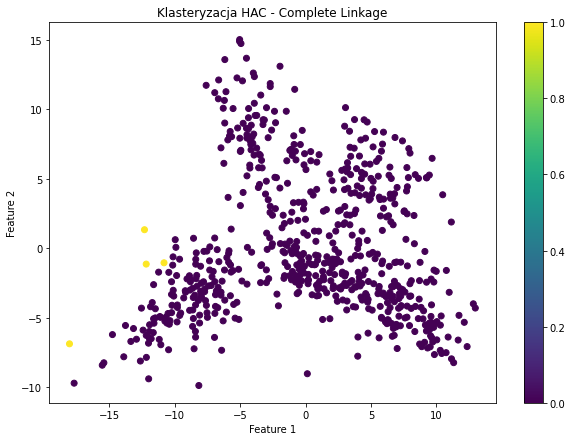

In [57]:
y_cl_glove = complete_linkage_plot(df_glove, max_clusters=2)

In [58]:
cl_silh_glove, cl_dbi_glove, cl_chs_glove = clusterization_scores(df_glove, y_cl_glove)

Silhouette Score: 0.2846532722404184
Davies-Bouldin Index: 1.4644257035232386
Calinski-Harabasz Index: 7.32630221171063


<font color="red">Wyniki wszystkich modeli zostały zaprezentowane wyłącznie za pomocą PCA. Być może warto byłoby skorzystać z innych technik wizualizacji, np. t-SNE. Być może wtedy byłoby widać coś więcej.</font>

##### Podsumowanie

In [63]:
cl_scores = {
    'Data': ['features_reduced_400', 'features_reduced_598', 'word2vec_features', 'ngram_features', 'glove_features'],
    'Silhouette Score': [cl_silh400, cl_silh598, cl_silh_w2v, cl_silh_ngram, cl_silh_glove],
    'Davies-Bouldin Score': [cl_dbi400, cl_dbi598, cl_dbi_w2v, cl_dbi_ngram, cl_dbi_glove],
    'Calinski-Harabasz Score': [cl_chs400, cl_chs598, cl_chs_w2v, cl_chs_ngram, cl_chs_glove]
    }

cl_scores = pd.DataFrame(cl_scores)
print(cl_scores)

                   Data  Silhouette Score  Davies-Bouldin Score  \
0  features_reduced_400          0.031629              3.550358   
1  features_reduced_598          0.035815              3.215980   
2     word2vec_features          0.137684              1.920808   
3        ngram_features          0.631242              0.203146   
4        glove_features          0.284653              1.464426   

   Calinski-Harabasz Score  
0                14.283342  
1                13.937352  
2                20.849401  
3                35.452502  
4                 7.326302  


#### Average Linkage

In [64]:
def average_linkage_plot(X, n_clusters=None):
    """
    Przeprowadza klasteryzację Average Linkage i rysuje wykres klastrów.
    
    :param X: przekształcone i zwektoryzowane dane tekstowe
    :param n_clusters: liczba klastrów
    """
    # Klasteryzacja Average Linkage
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
    labels = model.fit_predict(X)
    
    # Redukcja wymiarów za pomocą PCA do 2D dla wizualizacji
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)
    
    # Rysowanie wykresu klastrów
    plt.figure(figsize=(10, 7))
    for i in range(n_clusters):
        plt.scatter(X_reduced[labels == i, 0], X_reduced[labels == i, 1], label=f'Cluster {i+1}')
    
    plt.title('Klasteryzacja HAC - Average Linkage')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()
    
    return labels

#### features_reduced_400

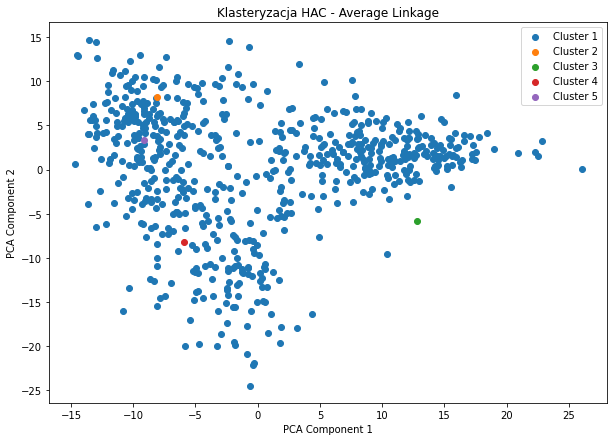

In [65]:
y_al400 = average_linkage_plot(df_train400, n_clusters=5)

In [66]:
al_silh400, al_dbi400, al_chs400 = clusterization_scores(df_train400, y_al400)

Silhouette Score: 0.12254312211325641
Davies-Bouldin Index: 0.7294761062792939
Calinski-Harabasz Index: 1.8964865380104619


#### features_reduced_598

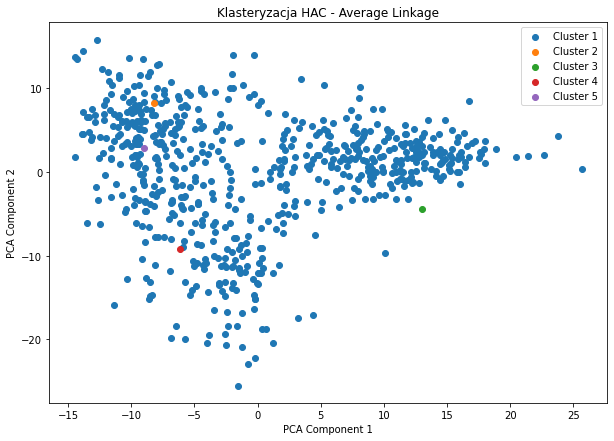

In [67]:
y_al598 = average_linkage_plot(df_train598, n_clusters=5)

In [68]:
al_silh598, al_dbi598, al_chs598 = clusterization_scores(df_train598, y_al598)

Silhouette Score: 0.11541800280206349
Davies-Bouldin Index: 0.7373554567271631
Calinski-Harabasz Index: 1.8642007034296324


#### word2vec_features

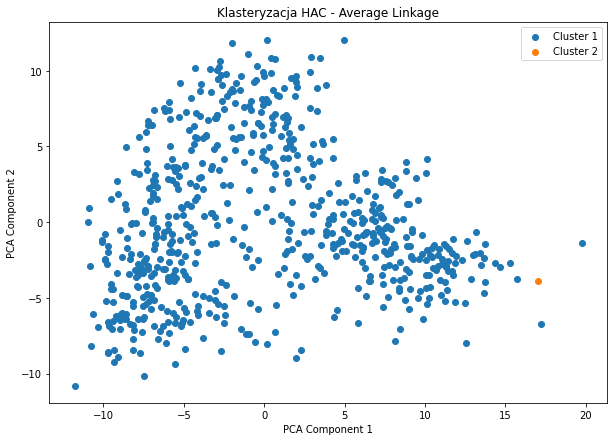

In [69]:
y_al_w2v = average_linkage_plot(df_word2vec, n_clusters=2)

In [70]:
al_silh_w2v, al_dbi_w2v, al_chs_w2v = clusterization_scores(df_word2vec, y_al_w2v)

Silhouette Score: 0.33997800473764034
Davies-Bouldin Index: 0.5195102562042166
Calinski-Harabasz Index: 3.590112038528145


#### tfidf_features

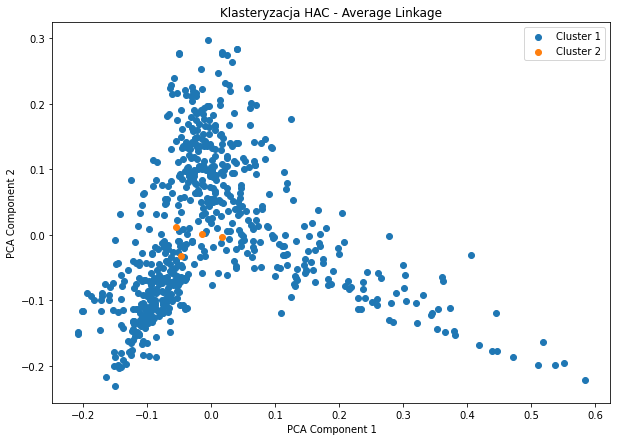

In [71]:
y_al_tfidf = average_linkage_plot(df_tfidf, n_clusters=2)

In [72]:
al_silh_tfidf, al_dbi_tfidf, al_chs_tfidf = clusterization_scores(df_tfidf, y_al_tfidf)

Silhouette Score: 0.00878224379311013
Davies-Bouldin Index: 3.5059072310934023
Calinski-Harabasz Index: 1.1272870487862725


#### ngram_features

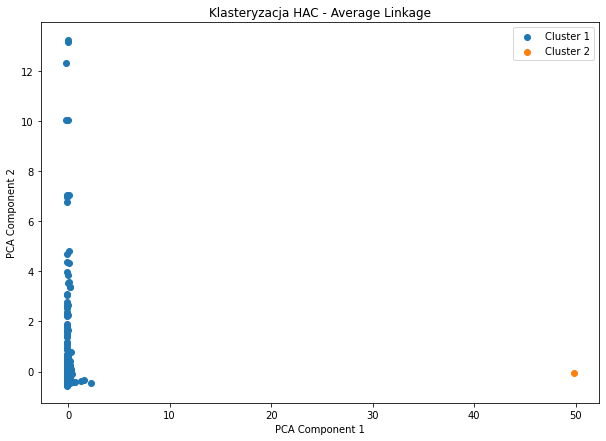

In [73]:
y_al_ngram = average_linkage_plot(df_ngram, n_clusters=2)

In [74]:
al_silh_ngram, al_dbi_ngram, al_chs_ngram = clusterization_scores(df_ngram, y_al_ngram)

Silhouette Score: 0.8500618288892711
Davies-Bouldin Index: 0.09969753110573597
Calinski-Harabasz Index: 73.4437525861839


#### glove_features

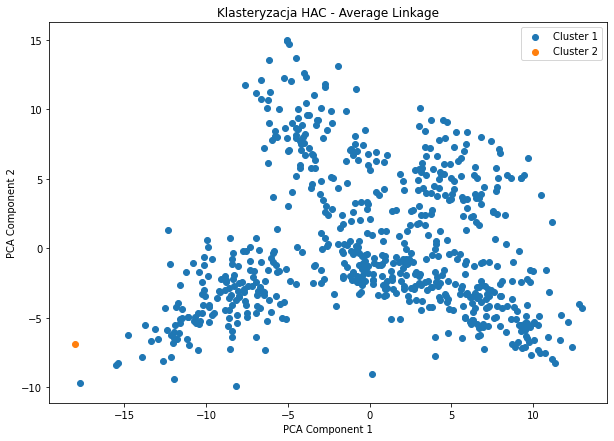

In [75]:
y_al_glove = average_linkage_plot(df_glove, n_clusters=2)

In [76]:
al_silh_glove, al_dbi_glove, al_chs_glove = clusterization_scores(df_glove, y_al_glove)

Silhouette Score: 0.4129899871496882
Davies-Bouldin Index: 0.44977715982065775
Calinski-Harabasz Index: 4.729709345149715


#### Podsumowanie

In [77]:
al_scores = {
    'Data': ['features_reduced_400', 'features_reduced_598', 'word2vec_features', 'tfidf_features', 'ngram_features', 'glove_features'],
    'Silhouette Score': [al_silh400, al_silh598, al_silh_w2v, al_silh_tfidf, al_silh_ngram, al_silh_glove],
    'Davies-Bouldin Score': [al_dbi400, al_dbi598, al_dbi_w2v, al_dbi_tfidf, al_dbi_ngram, al_dbi_glove],
    'Calinski-Harabasz Score': [al_chs400, al_chs598, al_chs_w2v, al_chs_tfidf, al_chs_ngram, al_chs_glove]
    }

al_scores = pd.DataFrame(al_scores)
print(al_scores)

                   Data  Silhouette Score  Davies-Bouldin Score  \
0  features_reduced_400          0.122543              0.729476   
1  features_reduced_598          0.115418              0.737355   
2     word2vec_features          0.339978              0.519510   
3        tfidf_features          0.008782              3.505907   
4        ngram_features          0.850062              0.099698   
5        glove_features          0.412990              0.449777   

   Calinski-Harabasz Score  
0                 1.896487  
1                 1.864201  
2                 3.590112  
3                 1.127287  
4                73.443753  
5                 4.729709  


#### Centroid Linkage

In [78]:
def centroid_linkage_plot(X, n_clusters=None):
    """
    Przeprowadza klasteryzację Centroid Linkage i rysuje wykres klastrów.
    
    :param X: przekształcone i zwektoryzowane dane tekstowe
    :param n_clusters: liczba klastrów
    """
    # Klasteryzacja Centroid Linkage
    Z = linkage(X, method='centroid')
    labels = fcluster(Z, n_clusters, criterion='maxclust')
    
    # Redukcja wymiarów za pomocą PCA do 2D dla wizualizacji
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)
    
    # Rysowanie wykresu klastrów
    plt.figure(figsize=(10, 7))
    for i in range(1, n_clusters + 1):
        plt.scatter(X_reduced[labels == i, 0], X_reduced[labels == i, 1], label=f'Cluster {i}')
    
    plt.title('Klasteryzacja HAC - Centroid Linkage')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()

    return labels

#### features_reduced_400

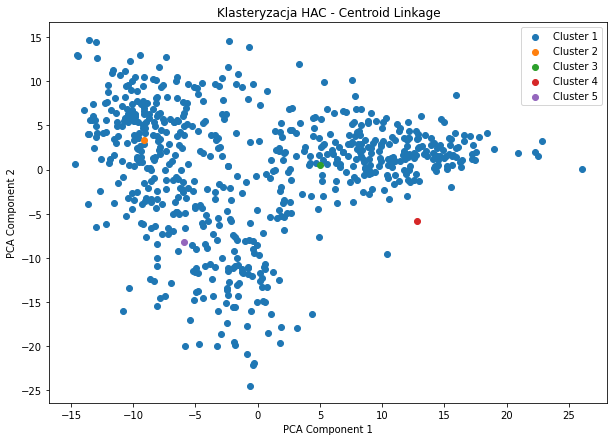

In [79]:
y_ctrl400 = centroid_linkage_plot(df_train400, n_clusters=5)

In [80]:
ctrl_silh400, ctrl_dbi400, ctrl_chs400 = clusterization_scores(df_train400, y_ctrl400)

Silhouette Score: 0.13170242149027803
Davies-Bouldin Index: 0.7192648440139047
Calinski-Harabasz Index: 1.949757251130017


#### features_reduced_598

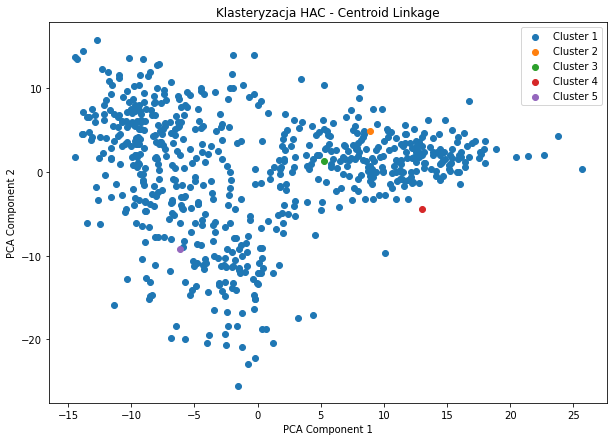

In [81]:
y_ctrl598 = centroid_linkage_plot(df_train598, n_clusters=5)

In [82]:
ctrl_silh598, ctrl_dbi598, ctrl_chs598 = clusterization_scores(df_train598, y_ctrl598)

Silhouette Score: 0.13428732196225274
Davies-Bouldin Index: 0.7251864490736466
Calinski-Harabasz Index: 1.9171549399018804


#### word2vec_features

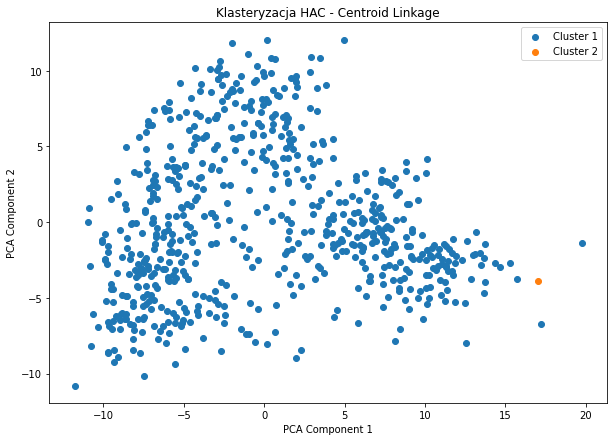

In [83]:
y_ctrl_w2v = centroid_linkage_plot(df_word2vec, n_clusters=2)

In [84]:
ctrl_silh_w2v, ctrl_dbi_w2v, ctrl_chs_w2v = clusterization_scores(df_word2vec, y_ctrl_w2v)

Silhouette Score: 0.33997800473764034
Davies-Bouldin Index: 0.5195102562042166
Calinski-Harabasz Index: 3.590112038528145


#### tfidf_features

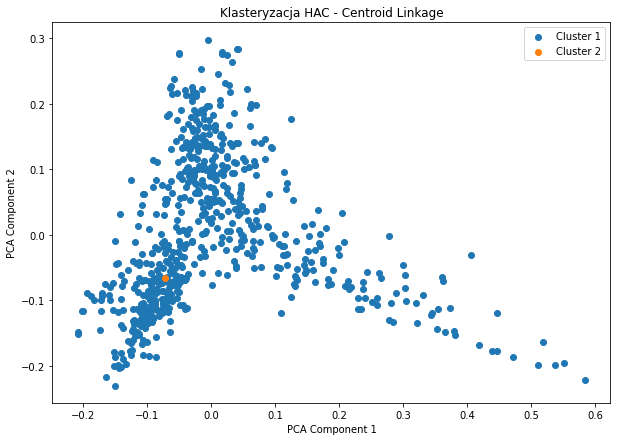

In [85]:
y_ctrl_tfidf = centroid_linkage_plot(df_tfidf, n_clusters=2)

In [86]:
ctrl_silh_tfidf, ctrl_dbi_tfidf, ctrl_chs_tfidf = clusterization_scores(df_tfidf, y_ctrl_tfidf)

Silhouette Score: 0.012315743495673276
Davies-Bouldin Index: 0.9745793488908693
Calinski-Harabasz Index: 1.0495446379268623


#### ngram_features

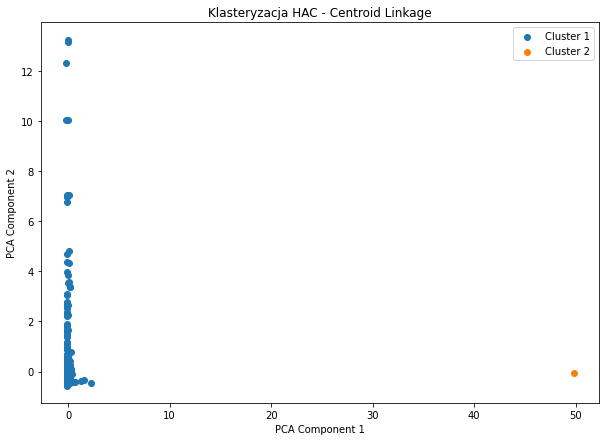

In [87]:
y_ctrl_ngram = centroid_linkage_plot(df_ngram, n_clusters=2)

In [88]:
ctrl_silh_ngram, ctrl_dbi_ngram, ctrl_chs_ngram = clusterization_scores(df_ngram, y_ctrl_ngram)

Silhouette Score: 0.8500618288892711
Davies-Bouldin Index: 0.09969753110573597
Calinski-Harabasz Index: 73.4437525861839


#### glove_features

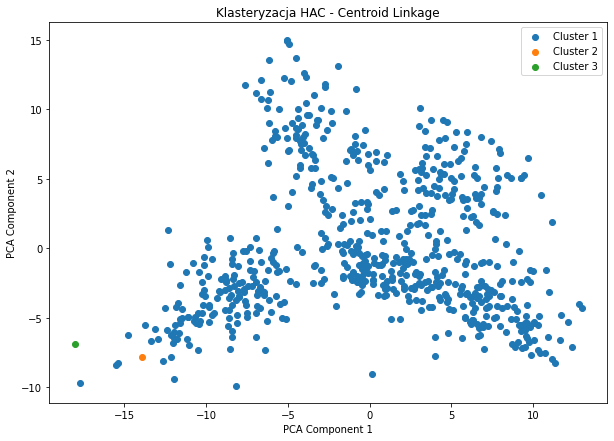

In [89]:
y_ctrl_glove = centroid_linkage_plot(df_glove, n_clusters=3)

In [90]:
ctrl_silh_glove, ctrl_dbi_glove, ctrl_chs_glove = clusterization_scores(df_glove, y_ctrl_glove)

Silhouette Score: 0.36078248227331744
Davies-Bouldin Index: 0.477464445406883
Calinski-Harabasz Index: 4.356562494872634


#### Podsumowanie

In [91]:
ctrl_scores = {
    'Data': ['features_reduced_400', 'features_reduced_598', 'word2vec_features', 'tfidf_features', 'ngram_features', 'glove_features'],
    'Silhouette Score': [ctrl_silh400, ctrl_silh598, ctrl_silh_w2v, ctrl_silh_tfidf, ctrl_silh_ngram, ctrl_silh_glove],
    'Davies-Bouldin Score': [ctrl_dbi400, ctrl_dbi598, ctrl_dbi_w2v, ctrl_dbi_tfidf, ctrl_dbi_ngram, ctrl_dbi_glove],
    'Calinski-Harabasz Score': [ctrl_chs400, ctrl_chs598, ctrl_chs_w2v, ctrl_chs_tfidf, ctrl_chs_ngram, ctrl_chs_glove]
    }

ctrl_scores = pd.DataFrame(ctrl_scores)
print(ctrl_scores)

                   Data  Silhouette Score  Davies-Bouldin Score  \
0  features_reduced_400          0.131702              0.719265   
1  features_reduced_598          0.134287              0.725186   
2     word2vec_features          0.339978              0.519510   
3        tfidf_features          0.012316              0.974579   
4        ngram_features          0.850062              0.099698   
5        glove_features          0.360782              0.477464   

   Calinski-Harabasz Score  
0                 1.949757  
1                 1.917155  
2                 3.590112  
3                 1.049545  
4                73.443753  
5                 4.356562  


#### Ward's Linkage

In [92]:
def ward_linkage_plot(X, n_clusters=None, distance_threshold=None, linkage_method='ward'):
    """
    Przeprowadza hierarchiczną klasteryzację aglomeracyjną i rysuje dendrogram.
    
    :param X: przekształcone i zwektoryzowane dane tekstowe (np. TF-IDF lub embeddings)
    :param n_clusters: liczba klastrów (opcjonalnie, jeśli chcemy określić liczbę klastrów)
    :param distance_threshold: próg odległości dla tworzenia klastrów (jeśli nie podano n_clusters)
    :param linkage_method: metoda łączenia klastrów ('ward', 'single', 'complete', 'average')
    """
    # Przeprowadzenie hierarchicznej klasteryzacji aglomeracyjnej
    hac = AgglomerativeClustering(n_clusters=n_clusters, 
                                  distance_threshold=distance_threshold, 
                                  metric='euclidean', 
                                  linkage=linkage_method)
    hac.fit(X)
    
    labels = hac.labels_

    
    # Redukcja wymiarowości danych do dwóch wymiarów za pomocą PCA dla wizualizacji
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Rysowanie klastrów
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hac.labels_, cmap='viridis')
    plt.title('Klasteryzacja HAC - Wards Linkage')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Cluster')
    plt.show()

    return labels


#### features_reduced_400

Najpierw dane z 400 kolumnami.

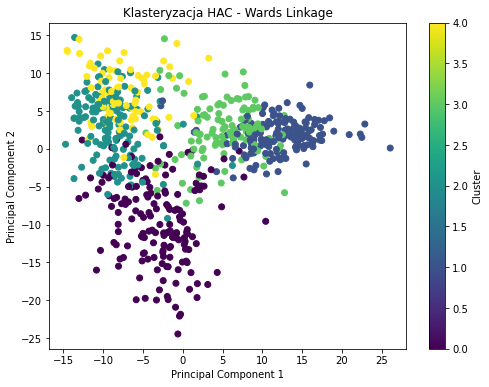

In [93]:
y_wl400 = ward_linkage_plot(df_train400, n_clusters=5)

In [94]:
wl_silh400, wl_dbi400, wl_chs400 = clusterization_scores(df_train400, y_wl400)

Silhouette Score: 0.051360118227151454
Davies-Bouldin Index: 3.7860923031754132
Calinski-Harabasz Index: 23.291391263326904


#### features_reduced_598

Teraz dane z 598 kolumnami:

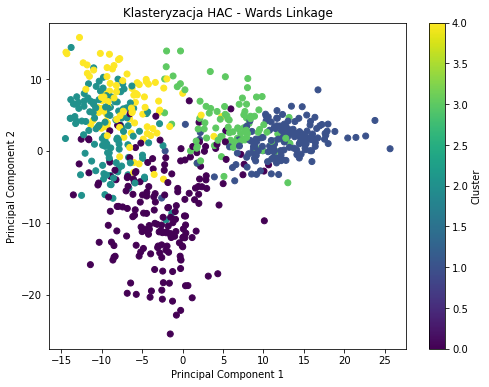

In [95]:
y_wl598 = ward_linkage_plot(df_train598, n_clusters=5)

In [96]:
wl_silh598, wl_dbi598, wl_chs598 = clusterization_scores(df_train598, y_wl598)

Silhouette Score: 0.04607905625664114
Davies-Bouldin Index: 3.8933784839379344
Calinski-Harabasz Index: 21.257612475654295


#### word2vec_features

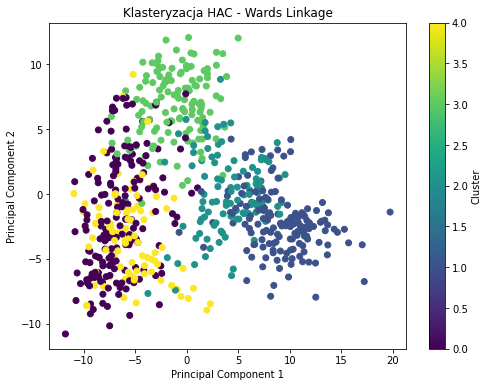

In [97]:
y_wl_w2v = ward_linkage_plot(df_word2vec, n_clusters=5)

In [98]:
wl_silh_w2v, wl_dbi_w2v, wl_chs_w2v = clusterization_scores(df_word2vec, y_wl_w2v)

Silhouette Score: 0.10815779117337923
Davies-Bouldin Index: 2.444056107117417
Calinski-Harabasz Index: 57.871818438555906


#### tfidf_features

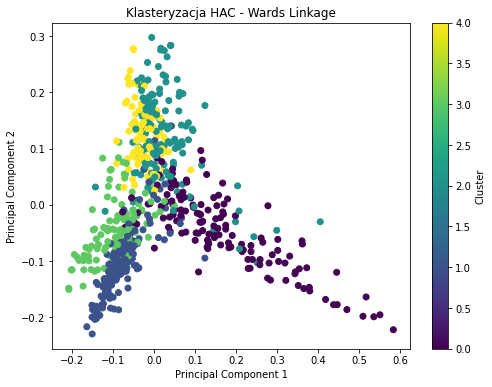

In [99]:
y_wl_tfidf = ward_linkage_plot(df_tfidf, n_clusters=5)

In [100]:
wl_silh_tfidf, wl_dbi_tfidf, wl_chs_tfidf = clusterization_scores(df_tfidf, y_wl_tfidf)

Silhouette Score: 0.015279304572395163
Davies-Bouldin Index: 6.8724995987854625
Calinski-Harabasz Index: 6.181207316154086


#### ngram_features

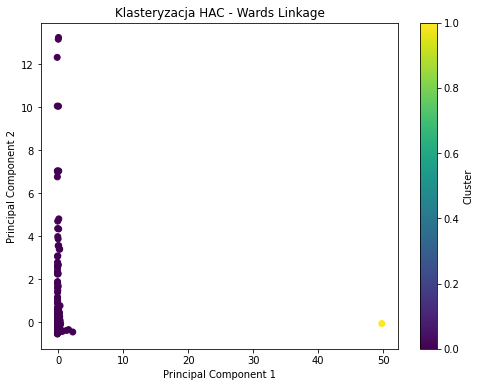

In [101]:
y_wl_ngram = ward_linkage_plot(df_ngram, n_clusters=2)

In [102]:
wl_silh_ngram, wl_dbi_ngram, wl_chs_ngram = clusterization_scores(df_ngram, y_wl_ngram)

Silhouette Score: 0.8500618288892711
Davies-Bouldin Index: 0.09969753110573597
Calinski-Harabasz Index: 73.4437525861839


#### glove_features

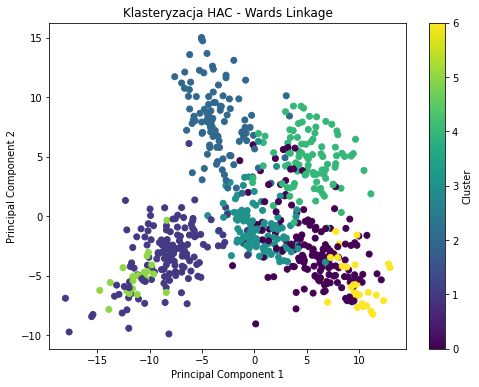

In [103]:
y_wl_glove = ward_linkage_plot(df_glove, n_clusters=7)

In [104]:
wl_silh_glove, wl_dbi_glove, wl_chs_glove = clusterization_scores(df_glove, y_wl_glove)

Silhouette Score: 0.11191125983761216
Davies-Bouldin Index: 2.239193016440854
Calinski-Harabasz Index: 49.97806042834863


#### Podsumowanie

In [105]:
wl_scores = {
    'Data': ['features_reduced_400', 'features_reduced_598', 'word2vec_features', 'tfidf_features', 'ngram_features', 'glove_features'],
    'Silhouette Score': [wl_silh400, wl_silh598, wl_silh_w2v, wl_silh_tfidf, wl_silh_ngram, wl_silh_glove],
    'Davies-Bouldin Score': [wl_dbi400, wl_dbi598, wl_dbi_w2v, wl_dbi_tfidf, wl_dbi_ngram, wl_dbi_glove],
    'Calinski-Harabasz Score': [wl_chs400, wl_chs598, wl_chs_w2v, wl_chs_tfidf, wl_chs_ngram, wl_chs_glove]
    }

wl_scores = pd.DataFrame(wl_scores)
print(wl_scores)

                   Data  Silhouette Score  Davies-Bouldin Score  \
0  features_reduced_400          0.051360              3.786092   
1  features_reduced_598          0.046079              3.893378   
2     word2vec_features          0.108158              2.444056   
3        tfidf_features          0.015279              6.872500   
4        ngram_features          0.850062              0.099698   
5        glove_features          0.111911              2.239193   

   Calinski-Harabasz Score  
0                23.291391  
1                21.257612  
2                57.871818  
3                 6.181207  
4                73.443753  
5                49.978060  


#### Divisive Clustering (DIANA)

In [106]:
# def diana_clustering(X, max_clusters):
#     """
#     Przeprowadza klasteryzację DIANA na danych X.
    
#     :param X: przekształcone i zwektoryzowane dane tekstowe
#     :param max_clusters: maksymalna liczba klastrów
#     :return: przyporządkowane klastry dla każdego punktu danych
#     """
#     distances = euclidean_distances(X)
#     num_points = len(X)
#     clusters = [[i] for i in range(num_points)]

#     while len(clusters) < max_clusters:
#         largest_cluster_idx = np.argmax([len(cluster) for cluster in clusters])
#         largest_cluster = clusters.pop(largest_cluster_idx)

#         if len(largest_cluster) <= 1:
#             clusters.append(largest_cluster)
#             continue

#         sub_dist_matrix = distances[np.ix_(largest_cluster, largest_cluster)]
#         max_distance_index = np.unravel_index(np.argmax(sub_dist_matrix), sub_dist_matrix.shape)

#         cluster1_index = largest_cluster[max_distance_index[0]]
#         cluster2_index = largest_cluster[max_distance_index[1]]

#         new_cluster = clusters[-1][-1] + 1

#         clusters.append(largest_cluster[:max_distance_index[0]] + largest_cluster[max_distance_index[0] + 1:max_distance_index[1]] + largest_cluster[max_distance_index[1] + 1:] + [new_cluster])

#     # Przyporządkowanie klastrów dla każdego punktu danych
#     labels = np.zeros(num_points, dtype=int)
#     for i, cluster in enumerate(clusters):
#         for point_idx in cluster:
#             labels[point_idx] = i

#     return labels

def diana_clustering(X, num_clusters):
    # Przeprowadzenie klasteryzacji algorytmem DIANA
    Z = linkage(X, method='ward')  # Użycie 'ward' jako przykład hierarchicznej klasteryzacji

    # Tworzenie klastrów (np. 3 klastry)
    labels = fcluster(Z, t=num_clusters, criterion='maxclust')

    return labels


def diana_plot(X, max_clusters):
    """
    Przeprowadza klasteryzację DIANA na danych X i rysuje wykres klastrów.
    
    :param X: przekształcone i zwektoryzowane dane tekstowe
    :param max_clusters: maksymalna liczba klastrów
    """
    labels = diana_clustering(X, max_clusters)

    # # silhouette score
    # score = silhouette_score(X, labels)
    # print(f'Silhouette score: {score}')

    # Redukcja wymiarowości danych do dwóch wymiarów za pomocą PCA dla wizualizacji
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(10, 7))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
    plt.title('DIANA Clustering')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar()
    plt.show()

    return labels



#### features_reduced_400

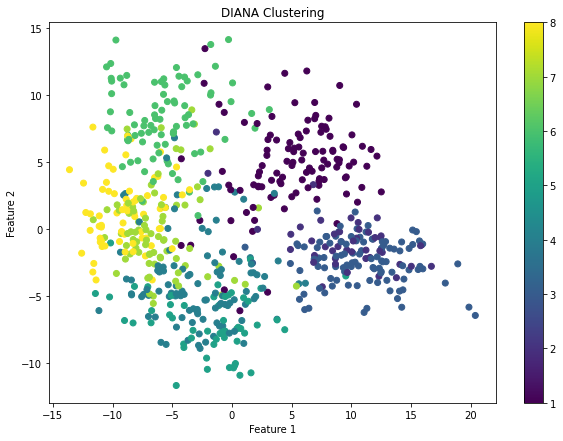

In [107]:
y_diana400 = diana_plot(df_train400, max_clusters=8)

In [108]:
diana_silh400, diana_dbi400, diana_chs400 = clusterization_scores(df_train400, y_diana400)

Silhouette Score: 0.03238026486715811
Davies-Bouldin Index: 4.468047922627807
Calinski-Harabasz Index: 16.284439037411865


#### features_reduced_598

Teraz zajmiemy się danymi z 598 kolumnami.

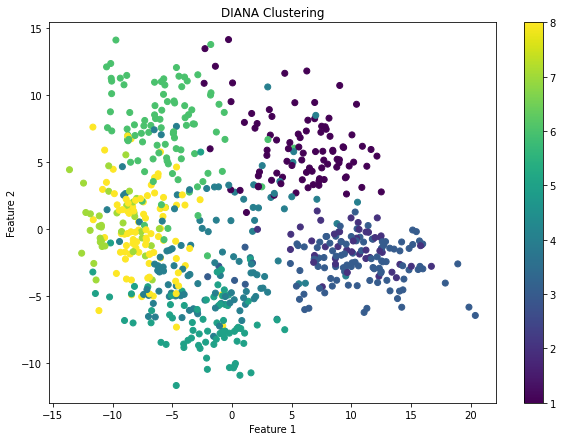

In [109]:
y_diana598 = diana_plot(df_train598, max_clusters=8)

In [110]:
diana_silh598, diana_dbi598, diana_chs598 = clusterization_scores(df_train598, y_diana598)

Silhouette Score: 0.02880946287985928
Davies-Bouldin Index: 4.560081974457329
Calinski-Harabasz Index: 15.113255150924667


#### word2vec_features

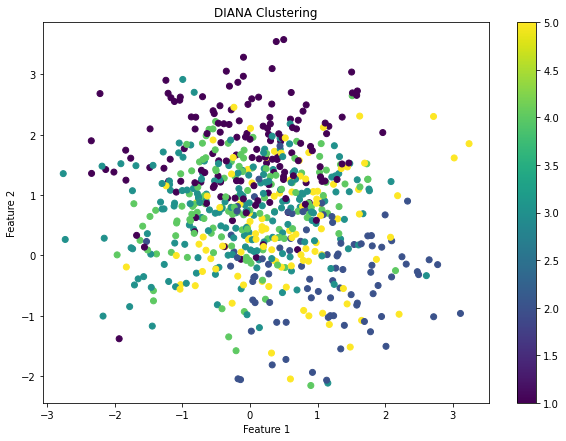

In [111]:
y_diana_w2v = diana_plot(df_word2vec, max_clusters=5)

In [112]:
diana_silh_w2v, diana_dbi_w2v, diana_chs_w2v = clusterization_scores(df_word2vec, y_diana_w2v)

Silhouette Score: 0.10815779117337923
Davies-Bouldin Index: 2.4440561071174165
Calinski-Harabasz Index: 57.87181843855591


#### tfidf_features

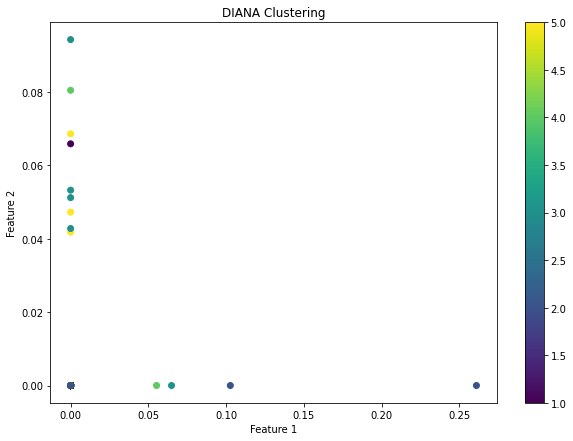

In [113]:
y_diana_tfidf = diana_plot(df_tfidf, max_clusters=5)

In [114]:
diana_silh_tfidf, diana_dbi_tfidf, diana_chs_tfidf = clusterization_scores(df_tfidf, y_diana_tfidf)

Silhouette Score: 0.015279304572395163
Davies-Bouldin Index: 6.872499598785464
Calinski-Harabasz Index: 6.181207316154086


#### ngram_features

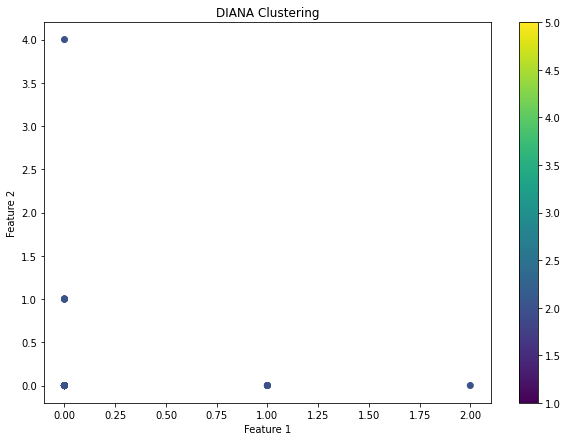

In [115]:
y_diana_ngram = diana_plot(df_ngram, max_clusters=5)

In [116]:
diana_silh_ngram, diana_dbi_ngram, diana_chs_ngram = clusterization_scores(df_ngram, y_diana_ngram)

Silhouette Score: 0.32355044556164647
Davies-Bouldin Index: 1.430326423570539
Calinski-Harabasz Index: 34.66542337112063


#### glove_features

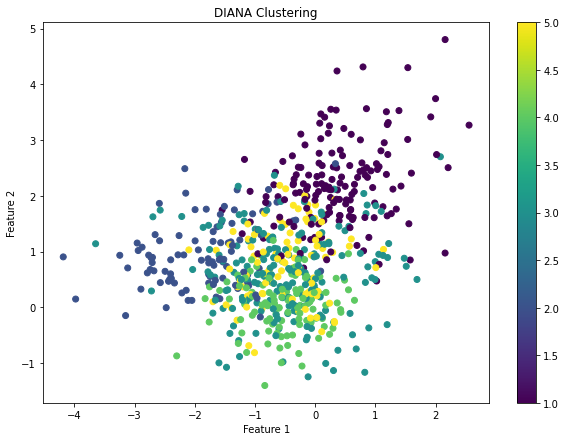

In [117]:
y_diana_glove = diana_plot(df_glove, max_clusters=5)

In [118]:
diana_silh_glove, diana_dbi_glove, diana_chs_glove = clusterization_scores(df_glove, y_diana_glove)

Silhouette Score: 0.10506809428410865
Davies-Bouldin Index: 2.2765913557140394
Calinski-Harabasz Index: 60.46740688763335


##### Podsumowanie

In [119]:
diana_scores = {
    'Data': ['features_reduced_400', 'features_reduced_598', 'word2vec_features', 'tfidf_features', 'ngram_features', 'glove_features'],
    'Silhouette Score': [diana_silh400, diana_silh598, diana_silh_w2v, diana_silh_tfidf, diana_silh_ngram, diana_silh_glove],
    'Davies-Bouldin Score': [diana_dbi400, diana_dbi598, diana_dbi_w2v, diana_dbi_tfidf, diana_dbi_ngram, diana_dbi_glove],
    'Calinski-Harabasz Score': [diana_chs400, diana_chs598, diana_chs_w2v, diana_chs_tfidf, diana_chs_ngram, diana_chs_glove]
    }

diana_scores = pd.DataFrame(diana_scores)
print(diana_scores)

                   Data  Silhouette Score  Davies-Bouldin Score  \
0  features_reduced_400          0.032380              4.468048   
1  features_reduced_598          0.028809              4.560082   
2     word2vec_features          0.108158              2.444056   
3        tfidf_features          0.015279              6.872500   
4        ngram_features          0.323550              1.430326   
5        glove_features          0.105068              2.276591   

   Calinski-Harabasz Score  
0                16.284439  
1                15.113255  
2                57.871818  
3                 6.181207  
4                34.665423  
5                60.467407  


<font color="red">Zespół budowy przetestował wiele, bo aż osiem modeli.  Każdy z nich został wytrenowany i uruchomiony na sześciu różnych zbiorach danych. Zespół budowy, na skutek naszej sugestii, zrezygnował z łączenia cech uzyskanych z różnych źródeł i wywołał model oddzielnie dla każdego zbioru cech. Dzięki temu wiadomo, który metoda ekstrakcji cech jest najskuteczniejsza w tym zadaniu klasteryzacji. </font>

## 4. Wybór i ocena algorytmów

Aby wybrać model, który poradził sobie najlepiej, przeanalizujemy wartości trzech wskaźników, które wyliczaliśmy na bieżąco:
- Silhouette Score (im wyższa wartość, tym lepsza klasteryzacja)
- Davies-Bouldin Score (im niższa wartość, tym lepsza klasteryzacja)
- Calinski-Harabasz Score (im wyższa wartość, tym lepsza klasteryzacja)


<font color="red">Brakuje interpretacji poszczególnych klastrów. Po wybraniu ostatecznego modelu, należy spojrzeć na oryginalną ramkę danych i na podstawie treści artykułu ustalić, co łączy teksty z jednego klastra. Niekoniecznie muszą to być takie tematy, jak na początku.</font> 

### Silhouette Score

In [121]:
silhouette = {
    'Algorithm': ['KMeans', 'HAC Single Linkage', 'HAC Complete Linkage', 'HAC Average Linkage', 'HAC Centroid Linkage', 'HAC Wards Linkage', 'DIANA'],
    'features_reduced_400': [kmeans_silh400, sl_silh400, cl_silh400, al_silh400, ctrl_silh400, wl_silh400, diana_silh400],
    'features_reduced_598': [kmeans_silh598, sl_silh598, cl_silh598, al_silh598, ctrl_silh598, wl_silh598, diana_silh598],
    'word2vec_features': [kmeans_silh_w2v, sl_silh_w2v, cl_silh_w2v, al_silh_w2v, ctrl_silh_w2v, wl_silh_w2v, diana_silh_w2v],
    # 'tfidf_features': [kmeans_silh_tfidf, sl_silh_tfidf, cl_silh_tfidf, al_silh_tfidf, ctrl_silh_tfidf, wl_silh_tfidf, diana_silh_tfidf],
    'ngram_features': [kmeans_silh_ngram, sl_silh_ngram, cl_silh_ngram, al_silh_ngram, ctrl_silh_ngram, wl_silh_ngram, diana_silh_ngram],
    'glove_features': [kmeans_silh_glove, sl_silh_glove, cl_silh_glove, al_silh_glove, ctrl_silh_glove, wl_silh_glove, diana_silh_glove]
    }

silhouette = pd.DataFrame(silhouette)
print(silhouette)

              Algorithm  features_reduced_400  features_reduced_598  \
0                KMeans              0.039851              0.036877   
1    HAC Single Linkage              0.195873              0.199948   
2  HAC Complete Linkage              0.031629              0.035815   
3   HAC Average Linkage              0.122543              0.115418   
4  HAC Centroid Linkage              0.131702              0.134287   
5     HAC Wards Linkage              0.051360              0.046079   
6                 DIANA              0.032380              0.028809   

   word2vec_features  ngram_features  glove_features  
0           0.125690        0.702342        0.133073  
1           0.339978        0.704780        0.284295  
2           0.137684        0.631242        0.284653  
3           0.339978        0.850062        0.412990  
4           0.339978        0.850062        0.360782  
5           0.108158        0.850062        0.111911  
6           0.108158        0.323550        0.

In [123]:
davies_bouldin_score = {
    'Algorithm': ['KMeans', 'HAC Single Linkage', 'HAC Complete Linkage', 'HAC Average Linkage', 'HAC Centroid Linkage', 'HAC Wards Linkage', 'DIANA'],
    'features_reduced_400': [kmeans_dbi400, sl_dbi400, cl_dbi400, al_dbi400, ctrl_dbi400, wl_dbi400, diana_dbi400],
    'features_reduced_598': [kmeans_dbi598, sl_dbi598, cl_dbi598, al_dbi598, ctrl_dbi598, wl_dbi598, diana_dbi598],
    'word2vec_features': [kmeans_dbi_w2v, sl_dbi_w2v, cl_dbi_w2v, al_dbi_w2v, ctrl_dbi_w2v, wl_dbi_w2v, diana_dbi_w2v],
    # 'tfidf_features': [kmeans_dbi_tfidf, sl_dbi_tfidf, cl_dbi_tfidf, al_dbi_tfidf, ctrl_dbi_tfidf, wl_dbi_tfidf, diana_dbi_tfidf],
    'ngram_features': [kmeans_dbi_ngram, sl_dbi_ngram, cl_dbi_ngram, al_dbi_ngram, ctrl_dbi_ngram, wl_dbi_ngram, diana_dbi_ngram],
    'glove_features': [kmeans_dbi_glove, sl_dbi_glove, cl_dbi_glove, al_dbi_glove, ctrl_dbi_glove, wl_dbi_glove, diana_dbi_glove]
    }

davies_bouldin_score = pd.DataFrame(davies_bouldin_score)
print(davies_bouldin_score)

              Algorithm  features_reduced_400  features_reduced_598  \
0                KMeans              4.241543              4.338805   
1    HAC Single Linkage              0.688626              0.683458   
2  HAC Complete Linkage              3.550358              3.215980   
3   HAC Average Linkage              0.729476              0.737355   
4  HAC Centroid Linkage              0.719265              0.725186   
5     HAC Wards Linkage              3.786092              3.893378   
6                 DIANA              4.468048              4.560082   

   word2vec_features  ngram_features  glove_features  
0           2.291017        0.204452        2.090382  
1           0.519510        0.167450        0.583444  
2           1.920808        0.203146        1.464426  
3           0.519510        0.099698        0.449777  
4           0.519510        0.099698        0.477464  
5           2.444056        0.099698        2.239193  
6           2.444056        1.430326        2.

In [124]:
calinski_harabasz_score = {
    'Algorithm': ['KMeans', 'HAC Single Linkage', 'HAC Complete Linkage', 'HAC Average Linkage', 'HAC Centroid Linkage', 'HAC Wards Linkage', 'DIANA'],
    'features_reduced_400': [kmeans_chs400, sl_chs400, cl_chs400, al_chs400, ctrl_chs400, wl_chs400, diana_chs400],
    'features_reduced_598': [kmeans_chs598, sl_chs598, cl_chs598, al_chs598, ctrl_chs598, wl_chs598, diana_chs598],
    'word2vec_features': [kmeans_chs_w2v, sl_chs_w2v, cl_chs_w2v, al_chs_w2v, ctrl_chs_w2v, wl_chs_w2v, diana_chs_w2v],
    # 'tfidf_features': [kmeans_chs_tfidf, sl_chs_tfidf, cl_chs_tfidf, al_chs_tfidf, ctrl_chs_tfidf, wl_chs_tfidf, diana_chs_tfidf],
    'ngram_features': [kmeans_chs_ngram, sl_chs_ngram, cl_chs_ngram, al_chs_ngram, ctrl_chs_ngram, wl_chs_ngram, diana_chs_ngram],
    'glove_features': [kmeans_chs_glove, sl_chs_glove, cl_chs_glove, al_chs_glove, ctrl_chs_glove, wl_chs_glove, diana_chs_glove]
    }

calinski_harabasz_score = pd.DataFrame(calinski_harabasz_score)
print(calinski_harabasz_score)

              Algorithm  features_reduced_400  features_reduced_598  \
0                KMeans             21.054054             19.930727   
1    HAC Single Linkage              2.074324              2.106520   
2  HAC Complete Linkage             14.283342             13.937352   
3   HAC Average Linkage              1.896487              1.864201   
4  HAC Centroid Linkage              1.949757              1.917155   
5     HAC Wards Linkage             23.291391             21.257612   
6                 DIANA             16.284439             15.113255   

   word2vec_features  ngram_features  glove_features  
0          62.315312       16.352566       58.954417  
1           3.590112       46.785047        2.807077  
2          20.849401       35.452502        7.326302  
3           3.590112       73.443753        4.729709  
4           3.590112       73.443753        4.356562  
5          57.871818       73.443753       49.978060  
6          57.871818       34.665423       60.

<font color="red">Mimo licznych podsumowań, brakuje informacji o tym, który model został ostatecznie wybrany. Umieszczone zostały wartości poszczególnych metryk, jednak nie wiadomo, który model na ich podstawie jest najlepszy. Nie można patrzeć wyłącznie na wartość jednej z nich. Na przykład Silhouette słabo działa w sytuacji, gdy mamy jeden duży klaster, a pozostałe znacznie mniejsze.</font> 